# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [2]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков

%matplotlib inline

Прочитаем исходные данные:

In [3]:
data = pd.read_csv('data/unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [4]:
# Описательные статистики для количественных переменных
quantitative_stats = data.describe()

# Выводим результаты
print("Описательные статистики для количественных переменных:")
print(quantitative_stats)

Описательные статистики для количественных переменных:
             Well         Por        Perm          AI     Brittle         TOC  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean   100.500000   14.991150    4.330750    2.968850   48.161950    0.990450   
std     57.879185    2.971176    1.731014    0.566885   14.129455    0.481588   
min      1.000000    6.550000    1.130000    1.280000   10.940000   -0.190000   
25%     50.750000   12.912500    3.122500    2.547500   37.755000    0.617500   
50%    100.500000   15.070000    4.035000    2.955000   49.510000    1.030000   
75%    150.250000   17.402500    5.287500    3.345000   58.262500    1.350000   
max    200.000000   23.550000    9.870000    4.630000   84.330000    2.180000   

               VR         Prod  
count  200.000000   200.000000  
mean     1.964300  4311.219852  
std      0.300827   992.038414  
min      0.930000  2107.139414  
25%      1.770000  3618.064513  
50%      1.960000

In [5]:
def plot_numerical_features_distribution(df, features, target):
    """
    Строит гистограммы и боксплоты для заданных числовых признаков.

    :param df: DataFrame с данными.
    :param features: Список числовых признаков для построения диаграмм.
    """
    numeric_columns = list(df.select_dtypes(include=['number']).columns)
    
    # Проверка на наличие указанных признаков в DataFrame
    for feature in features:
        if feature not in numeric_columns:
            raise ValueError(f"Признак '{feature}' не является числовым или отсутствует в DataFrame.")
    
    n = len(features)  # число числовых признаков
    fig, axes = plt.subplots(n, 2, figsize=(10, 5 * n))  # фигура + n * 2 координатных плоскостей
    
    # Строим в цикле гистограмму и распределение по всем числовым признакам  
    for i, feature in enumerate(features):
        # Строим гистограмму каждой из категорий в данных
        hist = sns.histplot(data=df, x=feature, kde=True, ax=axes[i][0])
        hist.xaxis.set_tick_params(rotation=60)
        axes[i][0].set_title(f'Гистограмма {feature}')
        
        box = sns.scatterplot(
            data=df,
            x=feature,
            y=target,
            hue=target,
            s=100,
            sizes=(50, 300),
            ax=axes[i][1]

        )
        box.xaxis.set_tick_params(rotation=60)
        axes[i][1].set_title(f'Боксплот {feature} по {target}')
        
        # # Посмотрим распределения в зависимости от целевой переменной
        # box = sns.boxplot(data=df, x=feature, y=target, hue=target, orient='h', ax=axes[i][1])
        # box.xaxis.set_tick_params(rotation=60)
        # axes[i][1].set_title(f'Боксплот {feature} по {target}')
    
    plt.tight_layout()  # выравнивание графиков
    plt.show()

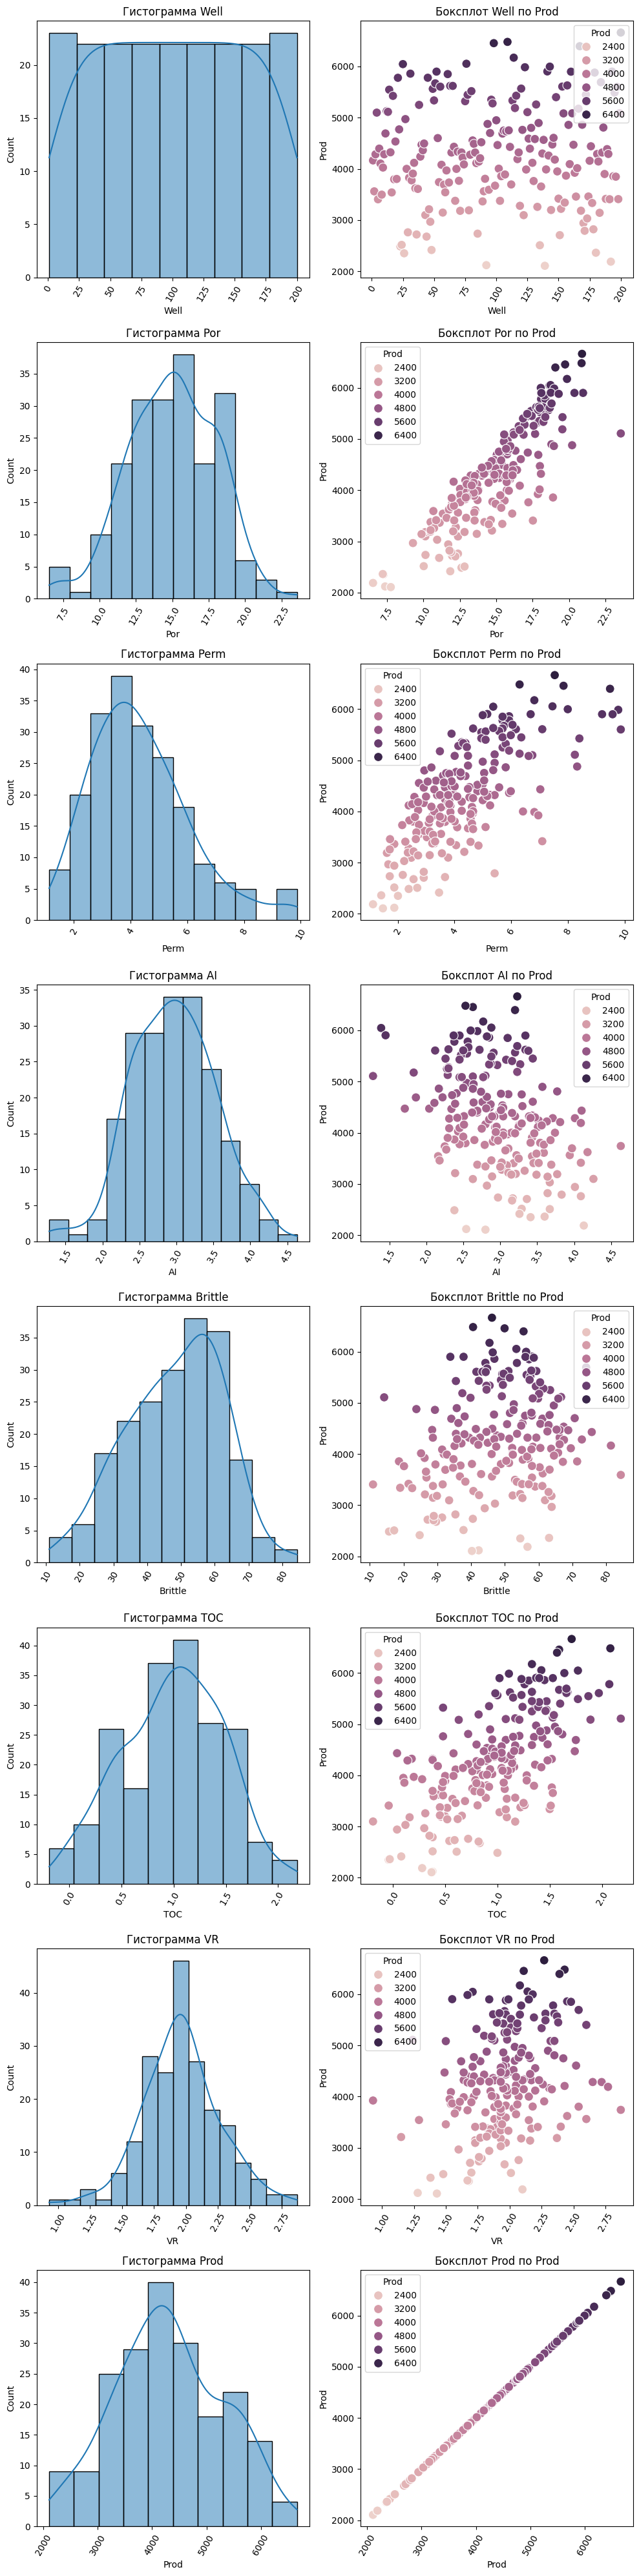

In [6]:
numeric_columns = list(data.select_dtypes(include=['number']).columns)
plot_numerical_features_distribution(data, numeric_columns, 'Prod')

ВЫВОДЫ: 
- все числовые признаки, кроме нумерации скважины имеют нормально распределение;
- явную прямую взаимосвязь целевого признака можно наблюдать по следующим факторам:
  - Por — пористость скважины (%);
  - Perm — проницаемость скважины;
  - TOC — общий органический углерод (%);
- для некоторых признаков можно наблюдать возрастание целевого признака Prod при приближении к определенному значению:
  - Brittle — коэффициент хрупкости скважины (%) при значении ~5.5;
  - VR — коэффициент отражения витринита (%) при значении ~2.25;

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

#### Расчёт корреляционной матрицы

In [7]:
# составляем матрицу
A = data[['Well', 'Por', 'Perm','AI','Brittle','TOC','VR', 'Prod']]

# стандартизируем векторы в столбцах матрицы A
A_cent = A - A.mean(axis=0)
A_st = A_cent/np.linalg.norm(A_cent, axis=0)
A_st.describe().round(2)

# матрица Грама
correlation_matrix = A_st.T @ A_st
print(correlation_matrix)

             Well       Por      Perm        AI   Brittle       TOC        VR  \
Well     1.000000  0.068927  0.077928  0.041483 -0.079252  0.022624 -0.007279   
Por      0.068927  1.000000  0.760546 -0.461549 -0.218570  0.711831  0.111860   
Perm     0.077928  0.760546  1.000000 -0.239636 -0.124017  0.471746  0.051023   
AI       0.041483 -0.461549 -0.239636  1.000000  0.127599 -0.531864  0.499143   
Brittle -0.079252 -0.218570 -0.124017  0.127599  1.000000 -0.214282  0.317929   
TOC      0.022624  0.711831  0.471746 -0.531864 -0.214282  1.000000  0.299483   
VR      -0.007279  0.111860  0.051023  0.499143  0.317929  0.299483  1.000000   
Prod     0.026817  0.861910  0.727426 -0.390835  0.237155  0.654445  0.323182   

             Prod  
Well     0.026817  
Por      0.861910  
Perm     0.727426  
AI      -0.390835  
Brittle  0.237155  
TOC      0.654445  
VR       0.323182  
Prod     1.000000  


#### Визуализация корреляционной матрицы в виде тепловой карты

<Axes: >

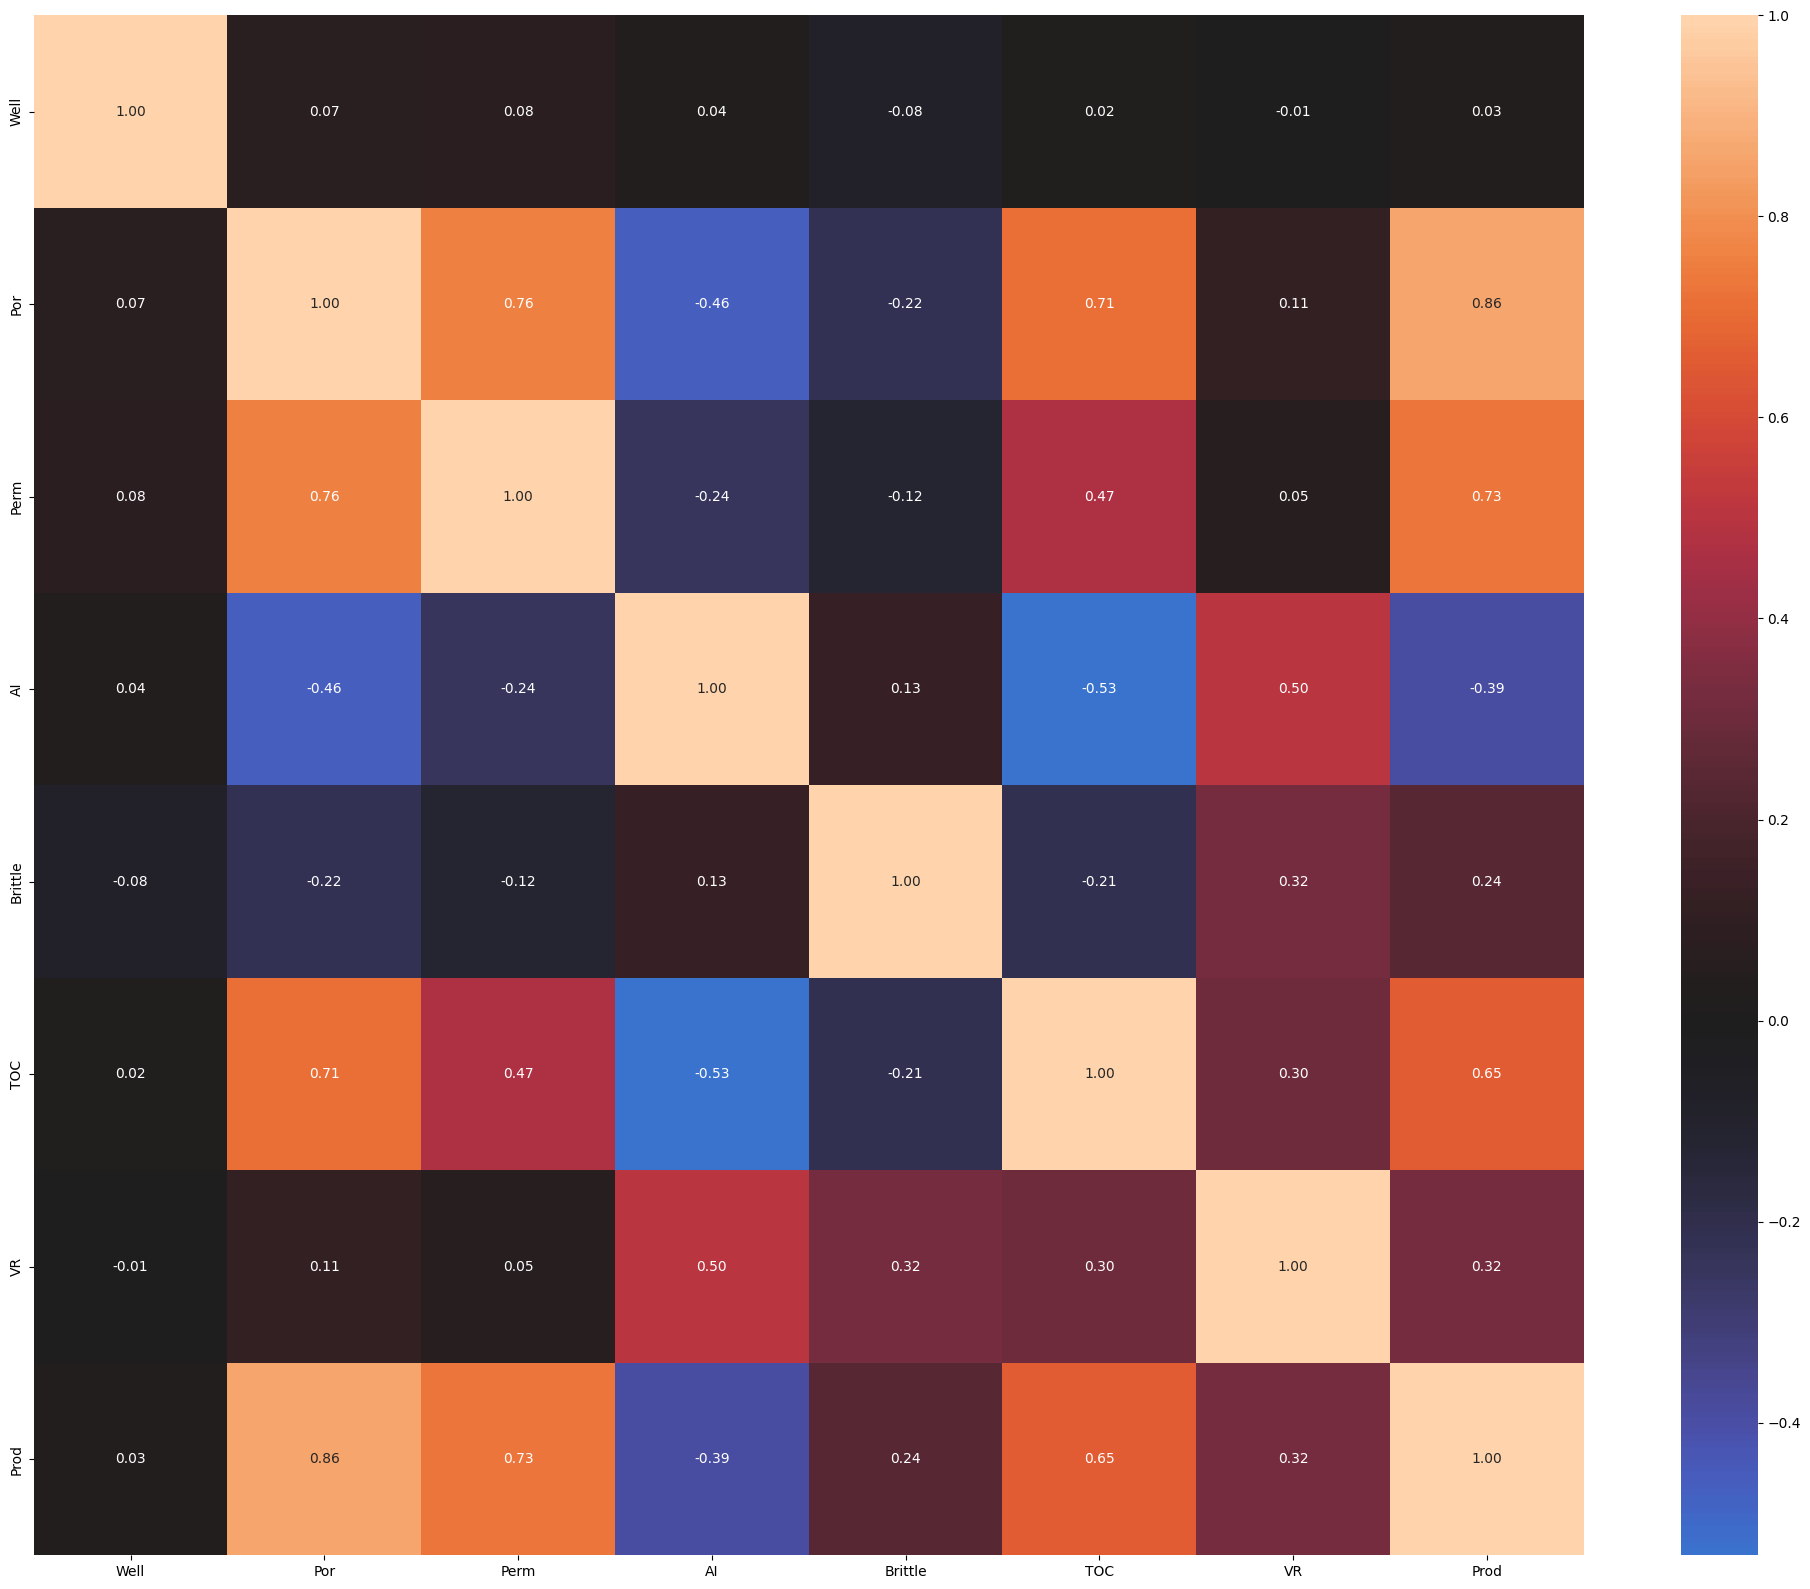

In [8]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(25,20))  
sns.heatmap(correlation_matrix,fmt='.2f',annot=True, center=0)

ВЫВОД: Сильнее всего коррелируют с целевой переменной факторы:
- Por — пористость скважины (%) = 0.86;
- Perm — проницаемость скважины = 0.73;
- TOC — общий органический углерод (%) = 0.65;

Между собой силнее всего коррелируют факторы: Por и Perm

#### Рассчет ранга и определителя корреляционной матрицы

In [9]:
# Вычисляем ранг корреляционной матрицы
rank = np.linalg.matrix_rank(correlation_matrix)

# Вычисляем определитель корреляционной матрицы
determinant = np.linalg.det(correlation_matrix)

print("Ранг корреляционной матрицы:", rank)
print("Определитель корреляционной матрицы (округленный):", format(determinant, '.7f'))

Ранг корреляционной матрицы: 8
Определитель корреляционной матрицы (округленный): 0.0007299


> ВЫВОДЫ
* Определитель близок к нулю (в данном случае 0.0007299), что указывает на возможность наличия линейной зависимости между переменными. Это может свидетельствовать о том, что матрица является плохо обусловленной. Если определитель корреляционной матрицы близок к нулю, это означает, что некоторые переменные могут быть линейно зависимыми, что делает матрицу неинверсируемой или почти неинверсируемой
* Корреляционная матрица показывает высокие коэффициенты корреляции между некоторыми переменными. Например, переменные Por и Perm  имеют коэффициент корреляции 0.760546. Эти значения указывают на наличие мультиколлинеарности в данных, что может привести к проблемам в оценке коэффициентов регрессии и увеличению стандартных ошибок.
* В данном случае применение модели линейной регрессии по методу наименьших квадратов может быть затруднительным из-за выявленной мультиколлинеарности. Хотя модель может быть применима, результаты могут быть ненадежными из-за высокой коррелированности независимых переменных. Это может привести к нестабильным оценкам коэффициентов и затруднениям в интерпретации их значимости36. Поэтому перед проведением регрессионного анализа целесообразно рассмотреть методы устранения мультиколлинеарности, такие как исключение одной из сильно коррелирующих переменных или использование методов регуляризации.

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

#### Нахождение параметров модели линейной регрессии с помощью матричной формулы МНК

In [10]:
# составляем матрицу наблюдений и вектор целевой переменной
x = data[['Well', 'Por', 'Perm','AI','Brittle','TOC','VR']]
x = np.column_stack((np.ones(200), x))
y = data[['Prod']]

# вычислим OLS-оценку для коэффициентов
w_hat=np.linalg.inv(x.T@x)@x.T@y

# Округляем значения до целых
w_hat_rounded = np.round(w_hat).astype(int)

# Выводим округленные значения
print(w_hat_rounded)

   Prod
0 -1232
1     0
2   230
3   116
4  -365
5    25
6   -78
7   785


> ВЫВОД

Неинформативные признаки: 
- Признак "Well": Коэффициент равен 0, что указывает на то, что идентификатор скважины не оказывает влияния на целевую переменную (добычу газа). Это может означать, что различия в идентификаторах скважин не связаны с изменениями в добыче газа, и этот признак можно считать неинформативным.


Интерпретация коэффициентов:
  - Признак "Por" (Пористость)
Коэффициент равен 230. Это означает, что при увеличении пористости скважины на 1% ожидается увеличение добычи газа на 230 млн кубических футов в сутки, при прочих равных условиях. Это указывает на положительное влияние пористости на добычу газа.
 - Признак "AI" (Акустический импеданс)
Коэффициент равен -365. Это означает, что при увеличении акустического импеданса на единицу ожидается снижение добычи газа на 365 млн кубических футов в сутки. Отрицательный знак указывает на то, что более высокий акустический импеданс ассоциируется с меньшей добычей газа.
 - Признак "VR" (Коэффициент отражения витринита)
Коэффициент равен 785. Это означает, что при увеличении коэффициента отражения витринита на единицу ожидается увеличение добычи газа на 785 млн кубических футов в сутки. Положительное влияние этого признака указывает на то, что более высокий коэффициент отражения витринита связан с большей добычей газа.

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

#### Построение прогноза выработки газа на указанной скважине

In [11]:
import json
json_data = '''
{
    "Well": 106.0,
    "Por": 15.32,
    "Perm": 3.71,
    "AI": 3.29,
    "Brittle": 55.99,
    "TOC": 1.35,
    "VR": 2.42
}
'''

# Десериализация JSON в словарь
data_dict = json.loads(json_data)

# Преобразование словаря в DataFrame
df = pd.DataFrame([data_dict])

# Преобразование DataFrame в массив NumPy и добавление 1 в начало
new_array = np.insert(df.to_numpy(), 0, 1, axis=1)

# Вывод результата
print(new_array)

prediction = (new_array@w_hat).values

print('prediction:', prediction)

[[  1.   106.    15.32   3.71   3.29  55.99   1.35   2.42]]
prediction: [[4723.06405371]]


In [12]:
# Фактическое значение добычи газа
actual_value = 4748.315024

# Прогнозируемое значение добычи газа
predicted_value = prediction[0][0]

# Расчет абсолютной ошибки
absolute_error = abs(actual_value - predicted_value)

# Вывод результата
print(f"Абсолютная ошибка: {absolute_error:.2f} миллионов кубических футов в день")

Абсолютная ошибка: 25.25 миллионов кубических футов в день


In [13]:
predictions = (x@w_hat).values

In [14]:
# Расчет MAE
mae = np.mean(np.abs(predictions.flatten() - y['Prod']))

# Расчет MSE
mse = np.mean((predictions.flatten() - y['Prod']) ** 2)

# Расчет MAPE
mape = np.mean(np.abs((y['Prod'] - predictions.flatten()) / y['Prod'])) * 100

# Вывод результатов
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Средняя квадратичная ошибка (MSE): {mse:.2f}")
print(f"Средняя абсолютная процентная ошибка (MAPE): {mape:.2f}%")

Средняя абсолютная ошибка (MAE): 153.62
Средняя квадратичная ошибка (MSE): 39315.04
Средняя абсолютная процентная ошибка (MAPE): 3.63%


>ВЫВОД:

Интерпретация полученных результатов
- MAE: MAE = 153, это означает, что в среднем предсказания модели отклоняются от фактических значений на 153 миллионов кубических футов в день.
- MSE: Если MSE равен 39315, это указывает на то, что средний квадрат ошибки составляет 39315 (миллионов кубических футов в день)². Это значение дает большее внимание большим ошибкам, что может быть полезно при оценке моделей, где важно минимизировать крупные отклонения.
- MAPE: MAPE равное 3.63%, это означает, что в среднем предсказания отклоняются от фактических значений на 3.63%. Это помогает оценить точность модели в относительных терминах и может быть полезно при сравнении различных моделей или подходов к прогнозированию.

Эти метрики дают представление о качестве модели и могут помочь в сравнении различных моделей регрессии для выбора наиболее подходящей.

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

>ВЫВОДЫ:

**Факторы с противоречивыми знаками**
- AI (Акустический импеданс):
Коэффициент корреляции: -0.390835 (отрицательная связь с "Prod")
Коэффициент регрессии: -365 (отрицательный)
Здесь наблюдается согласие между коэффициентом корреляции и коэффициентом регрессии, но важно отметить, что отрицательная связь указывает на то, что увеличение AI связано со снижением добычи газа.
- TOC (Общий органический углерод):
Коэффициент корреляции: 0.654445 (положительная связь с "Prod")
Коэффициент регрессии: -78 (отрицательный)
Это явное противоречие, так как корреляция указывает на положительную зависимость, а модель линейной регрессии показывает отрицательное влияние на добычу газа.

**Другие факторы:**
Для других факторов, таких как Por, Perm, и Brittle, наблюдается согласие между знаками коэффициентов корреляции и регрессии.

**Причины противоречий**
- Мультиколлинеарность:
Высокая степень взаимосвязи между независимыми переменными может привести к нестабильности оценок коэффициентов в модели линейной регрессии. Например, если Perm высоко коррелирует с Por, это может исказить его влияние на целевую переменную.
- Ложные корреляции:
Корреляция не указывает на причинно-следственную связь. Например, положительная корреляция между TOC и Prod может быть вызвана другими скрытыми переменными или факторами, которые не были учтены в модели.
- Нелинейные зависимости:
Если зависимость между переменными не является линейной, это также может привести к несоответствию между коэффициентами корреляции и регрессии.

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

#### Отбор факторов

**Анализ корреляционной матрицы**

На основе корреляционной матрицы:
- Por и Perm имеют высокую корреляцию (0.760546).
- Por и TOC также имеют высокую корреляцию (0.711831).

Сравнивая их коэффициенты корреляции с целевой переменной "Prod":
- Por: 0.861910
- Perm: 0.727426
- TOC: 0.654445

**На основании этого, мы оставим Por и исключим Perm и TOC, так как они имеют меньшую корреляцию с "Prod".**

**Исключение факторов с низкой корреляцией**

Факторы, которые имеют корреляцию с "Prod" ниже 0.05:
- Well: 0.026817

**Итоговые факторы для модели**
- Por (пористость)
- AI (акустический импеданс)
- Brittle (коэффициент хрупкости)
- VR (коэффициент отражения витринита)

#### Построение модели линейной регрессии с помощью матричной формулы МНК и поиск параметров модели, соответствующие каждому из факторов

In [15]:
# составляем матрицу наблюдений и вектор целевой переменной
x = data[['Por', 'AI','Brittle', 'VR']]
x = np.column_stack((np.ones(200), x))
y = data[['Prod']]

# вычислим OLS-оценку для коэффициентов
w_hat=np.linalg.inv(x.T@x)@x.T@y

# Округляем значения до целых
w_hat_rounded = np.round(w_hat).astype(int)

# Выводим округленные значения
print(w_hat_rounded)

   Prod
0 -1835
1   293
2  -200
3    28
4   517


#### Построение прогноза для всего обучающего набора данных и рассчет значение метрики

In [16]:
predictions = (x@w_hat).values

In [17]:
# Расчет MAE
mae = np.mean(np.abs(predictions.flatten() - y['Prod']))

# Расчет MSE
mse = np.mean((predictions.flatten() - y['Prod']) ** 2)

# Расчет MAPE
mape = np.mean(np.abs((y['Prod'] - predictions.flatten()) / y['Prod'])) * 100

# Вывод результатов
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Средняя квадратичная ошибка (MSE): {mse:.2f}")
print(f"Средняя абсолютная процентная ошибка (MAPE): {mape:.2f}%")

Средняя абсолютная ошибка (MAE): 171.43
Средняя квадратичная ошибка (MSE): 53660.85
Средняя абсолютная процентная ошибка (MAPE): 4.04%


> ВЫВОД:

**Интерпретация коэффициентов**

- Por (Пористость):
Коэффициент: 293

Интерпретация: Это означает, что при увеличении пористости скважины на 1% ожидается увеличение добычи газа на 293 миллиона кубических футов в день, при условии, что другие факторы остаются постоянными. Это значение указывает на значительное положительное влияние пористости на объем добычи газа.
- AI (Акустический импеданс):
Коэффициент: -200

Интерпретация: Этот коэффициент показывает, что при увеличении акустического импеданса на единицу ожидается снижение добычи газа на 200 миллионов кубических футов в день. Отрицательное значение указывает на то, что более высокий акустический импеданс ассоциирован с меньшей добычей газа, что может быть связано с тем, что высокие значения AI могут указывать на менее проницаемые породы.
- Brittle (Коэффициент хрупкости):
Коэффициент: 28

Интерпретация: Это значение говорит о том, что увеличение коэффициента хрупкости на 1% связано с увеличением добычи газа на 28 миллионов кубических футов в день. Хотя это влияние меньше по сравнению с пористостью, оно все же положительное и может указывать на то, что более хрупкие породы могут быть более эффективными для добычи газа.
- VR (Коэффициент отражения витринита):
Коэффициент: 517

Интерпретация: Увеличение коэффициента отражения витринита на единицу связано с увеличением добычи газа на 517 миллионов кубических футов в день. Это значение указывает на сильное положительное влияние этого фактора на объем добычи.

**Сравнив новые значения с предыдущими:**
- Коэффициент для Por увеличился с 230 до 293, что подтверждает его сильное влияние на добычу.
- Для AI значение изменилось с -365 до -200, что указывает на уменьшение отрицательного влияния этого фактора.
- Коэффициент для Brittle возрос с 25 до 28, показывая небольшое улучшение.
- Для VR, коэффициент уменьшился с 785 до 517, что может указывать на менее выраженное влияние этого фактора в новой модели.

**Изменения в значениях коэффициентов могут быть связаны с тем, как модель адаптируется к данным после исключения некоторых факторов**

**После исключения признаков увеличилась ошибка**
Было, со всеми признаками ('Well', 'Por', 'Perm','AI','Brittle','TOC','VR'):
- Средняя абсолютная ошибка (MAE): 153.62
- Средняя квадратичная ошибка (MSE): 39315.04
- Средняя абсолютная процентная ошибка (MAPE): 3.63%

Стало, после исключения, с признаками ('Por', 'AI','Brittle', 'VR):
- Средняя абсолютная ошибка (MAE): 171.43
- Средняя квадратичная ошибка (MSE): 53660.85
- Средняя абсолютная процентная ошибка (MAPE): 4.04%

**Увеличение ошибки после исключения признаков может быть связано с несколькими факторами. Давайте рассмотрим основные причины, которые могут объяснить, почему ваша модель стала менее точной после удаления некоторых переменных:**
1. Потеря информации

Когда исключили признаки, которые имели некоторую степень корреляции с целевой переменной, могли потерять важную информацию, которая могла бы помочь модели лучше предсказать целевую переменную. Даже если некоторые из этих признаков были коррелированы между собой, они могли вносить уникальную информацию в модель.

2. Мультиколлинеарность

Хотя мы исключили факторы с высокой корреляцией, это не всегда гарантирует улучшение модели. Иногда, наличие мультиколлинеарных факторов может помочь модели лучше справляться с шумом в данных. Удаление одного из факторов могло привести к тому, что оставшиеся факторы не смогут адекватно объяснить вариацию целевой переменной.

3. Нелинейные зависимости

Если в данных есть нелинейные зависимости между признаками и целевой переменной, линейная регрессия может не уловить эти зависимости должным образом. Исключение признаков может ухудшить качество модели, если оставшиеся факторы не способны объяснить сложные отношения.

4. Случайные колебания

В небольших выборках результаты могут варьироваться из-за случайных колебаний. Возможно, что увеличение ошибки является результатом случайности и не отражает истинного качества модели.

5. Неправильная интерпретация корреляции

Корреляция не всегда означает причинно-следственную связь. Признаки с высокой корреляцией могут не всегда быть полезными для предсказания целевой переменной. Например, если два признака имеют высокую корреляцию, это не гарантирует, что оба они нужны для построения модели.

**Также удалось побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции. Фактор, который ранее вызывал противоречие, был исключен из-за мультиколлиниарности. Новых противоречий нет**

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

#### Построение модели линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов

In [18]:
from sklearn.linear_model import LinearRegression
# создаём модель линейной регрессии
model = LinearRegression(fit_intercept=False)
# вычисляем коэффициенты регрессии
A = data[['Por', 'AI','Brittle', 'VR']]
model.fit(A, y)
# Выводим коэффициенты регрессии
print('Коэффициенты модели (w_hat):', model.coef_)


Коэффициенты модели (w_hat): [[ 235.18136665 -486.00139708   22.19245125  598.12844353]]


#### Построение прогноза для всего обучающего набора данных и рассчет значение метрики 

In [19]:
predictions = model.predict(A)
# Расчет метрик
mae = np.mean(np.abs(predictions - y))
mse = np.mean((predictions - y) ** 2)
mape = np.mean(np.abs((y - predictions) / y)) * 100

# Вывод результатов
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Средняя квадратичная ошибка (MSE): {mse:.2f}")
print(f"Средняя абсолютная процентная ошибка (MAPE): {mape:.2f}%")

Средняя абсолютная ошибка (MAE): 216.94
Средняя квадратичная ошибка (MSE): 81723.87
Средняя абсолютная процентная ошибка (MAPE): 5.03%


> ВЫВОД:

 Метрики предсказания модели, оцененные с помощью библиотеки, имеют большее значение MAE, MSE, MAPE по сравнению с ручным расчетом. 
 Возможно, в процессе подготовки данных для модели (например, стандартизация) произошли изменения, которые повлияли на результаты.

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [20]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

#### На основе отобранных факторов генерим полиномиальные признаки третьего порядка

In [21]:
data = pd.read_csv('data/unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


In [22]:
# составляем матрицу наблюдений и вектор целевой переменной
x = data[['Por', 'AI','Brittle', 'VR']]
#x = np.column_stack((np.ones(200), x))
y = data[['Prod']]

In [23]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(x)

#### Строим модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках)

In [24]:
# создаём модель линейной регрессии
lr = LinearRegression()

#### С помощью кросс-валидации оцениваем среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах

In [25]:
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Создание пользовательских метрик
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Оценка качества модели на кросс-валидации
cv_results_mae = cross_validate(lr, X, y, scoring=mae_scorer, cv=5, return_train_score=True)
cv_results_mse = cross_validate(lr, X, y, scoring=mse_scorer, cv=5, return_train_score=True)
cv_results_mape = cross_validate(lr, X, y, scoring=mape_scorer, cv=5, return_train_score=True)

# Вывод результатов
print('MAE на тренировочных фолдах: {:.2f}'.format(-cv_results_mae['train_score'].mean()))
print('MAE на валидационных фолдах: {:.2f}'.format(-cv_results_mae['test_score'].mean()))

print('MSE на тренировочных фолдах: {:.2f}'.format(-cv_results_mse['train_score'].mean()))
print('MSE на валидационных фолдах: {:.2f}'.format(-cv_results_mse['test_score'].mean()))

print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results_mape['train_score'].mean() * 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results_mape['test_score'].mean() * 100))

MAE на тренировочных фолдах: 75.35
MAE на валидационных фолдах: 110.47
MSE на тренировочных фолдах: 10162.07
MSE на валидационных фолдах: 24335.09
MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.68 %


> *Ваши выводы здесь*
Линейная регрессия на полиномиальных признаках значительно улучшила результат. 

**Интерпретация полученных результатов**
- MAE: **MAE = 110**, это означает, что в среднем предсказания модели отклоняются от фактических значений на 110 миллионов кубических футов в день.
- MSE: Если **MSE равен 24335**, это указывает на то, что средний квадрат ошибки составляет 24335 (миллионов кубических футов в день)². Это значение дает большее внимание большим ошибкам, что может быть полезно при оценке моделей, где важно минимизировать крупные отклонения.
- MAPE: **MAPE равное 2.68%**, это означает, что в среднем предсказания отклоняются от фактических значений на 2.68%. Это помогает оценить точность модели в относительных терминах и может быть полезно при сравнении различных моделей или подходов к прогнозированию.


### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

#### Построение модели полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso)

In [26]:
import optuna
from optuna.visualization import plot_optimization_history
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib
matplotlib.use('TkAgg')  # или 'Qt5Agg', 'GTK3Agg' в зависимости 
print("Версия Optuna: {}".format(optuna.__version__))

C:\Users\aoreshkin.IT-ONE\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Версия Optuna: 4.1.0


In [27]:
data = pd.read_csv('data/unconv.csv')
data.head()

# составляем матрицу наблюдений и вектор целевой переменной
x = data[['Por', 'AI','Brittle', 'VR']]
#x = np.column_stack((np.ones(200), x))
y = data[['Prod']]

# Инициализация стандартизатора
scaler = StandardScaler()
X = scaler.fit_transform(x)

# Добавление полиномиальных признаков
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)

# создаём модель линейной регрессии c L1-регуляризацией
lasso = Lasso(alpha=0.1, max_iter=10000)

# Создание пользовательских метрик
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Оценка качества модели на кросс-валидации
cv_results_mae = cross_validate(lasso, X, y, scoring=mae_scorer, cv=5, return_train_score=True)
cv_results_mse = cross_validate(lasso, X, y, scoring=mse_scorer, cv=5, return_train_score=True)
cv_results_mape = cross_validate(lasso, X, y, scoring=mape_scorer, cv=5, return_train_score=True)

# Вывод результатов
print('MAE на тренировочных фолдах: {:.2f}'.format(-cv_results_mae['train_score'].mean()))
print('MAE на валидационных фолдах: {:.2f}'.format(-cv_results_mae['test_score'].mean()))

print('MSE на тренировочных фолдах: {:.2f}'.format(-cv_results_mse['train_score'].mean()))
print('MSE на валидационных фолдах: {:.2f}'.format(-cv_results_mse['test_score'].mean()))

print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results_mape['train_score'].mean() * 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results_mape['test_score'].mean() * 100))

MAE на тренировочных фолдах: 75.22
MAE на валидационных фолдах: 108.90
MSE на тренировочных фолдах: 10172.19
MSE на валидационных фолдах: 23662.37
MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.64 %


#### Подбор параметра регуляризации 

In [28]:
data = pd.read_csv('data/unconv.csv')
data.head()

# составляем матрицу наблюдений и вектор целевой переменной
x = data[['Por', 'AI','Brittle', 'VR']]
#x = np.column_stack((np.ones(200), x))
y = data[['Prod']]

# Инициализация стандартизатора
scaler = StandardScaler()
X = scaler.fit_transform(x)

# Добавление полиномиальных признаков
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)

# Определение функции для оптимизации
def optimize_model(trial):
    # Определение гиперпараметров для оптимизации
    alpha = trial.suggest_loguniform('alpha', 0.01, 10.0)
    
    # Создание модели с оптимизируемыми гиперпараметрами
    model = Lasso(alpha=alpha, max_iter=10000)
    
    # Оценка модели на кросс-валидации
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=5)
    
    # Возвращение среднего значения MAPE
    return scores.mean()

# Запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(optimize_model, n_trials=50)

# Вывод лучших гиперпараметров и соответствующего MAPE
print('Лучшие гиперпараметры:', study.best_params)
print('Лучшее значение MAPE:', study.best_value)

# Визуализация истории оптимизации
optuna.visualization.plot_optimization_history(study)

[I 2024-12-21 22:20:13,849] A new study created in memory with name: no-name-34bd5b9c-cd29-49e2-a215-9e9142e38d38


C:\Users\aoreshkin.IT-ONE\AppData\Local\Temp\ipykernel_18248\1379304841.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.01, 10.0)
[I 2024-12-21 22:20:13,957] Trial 0 finished with value: -0.026479682891212976 and parameters: {'alpha': 0.0747873727802846}. Best is trial 0 with value: -0.026479682891212976.
C:\Users\aoreshkin.IT-ONE\AppData\Local\Temp\ipykernel_18248\1379304841.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.01, 10.0)
[I 2024-12-21 22:20:13,992] Trial 1 finished with value: -0.023159652070975912 and parameters: {'alpha': 3.0216315808875818}. Best is trial 1 w

Лучшие гиперпараметры: {'alpha': 4.652383619850158}
Лучшее значение MAPE: -0.02275563008845431


#### С помощью кросс-валидации оценка среднего значения метрик на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

In [36]:
data = pd.read_csv('data/unconv.csv')
data.head()

# составляем матрицу наблюдений и вектор целевой переменной
x = data[['Por', 'AI','Brittle', 'VR']]
#x = np.column_stack((np.ones(200), x))
y = data[['Prod']]

# Инициализация стандартизатора
scaler = StandardScaler()
X = scaler.fit_transform(x)

# Добавление полиномиальных признаков
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)

# создаём модель линейной регрессии c L1-регуляризацией
lasso = Lasso(alpha=4.832712647056475, max_iter=10000)

# Создание пользовательских метрик
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Оценка качества модели на кросс-валидации
cv_results_mae = cross_validate(lasso, X, y, scoring=mae_scorer, cv=5, return_train_score=True)
cv_results_mse = cross_validate(lasso, X, y, scoring=mse_scorer, cv=5, return_train_score=True)
cv_results_mape = cross_validate(lasso, X, y, scoring=mape_scorer, cv=5, return_train_score=True)

# Вывод результатов
print('MAE на тренировочных фолдах: {:.2f}'.format(-cv_results_mae['train_score'].mean()))
print('MAE на валидационных фолдах: {:.2f}'.format(-cv_results_mae['test_score'].mean()))

print('MSE на тренировочных фолдах: {:.2f}'.format(-cv_results_mse['train_score'].mean()))
print('MSE на валидационных фолдах: {:.2f}'.format(-cv_results_mse['test_score'].mean()))

print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results_mape['train_score'].mean() * 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results_mape['test_score'].mean() * 100))

MAE на тренировочных фолдах: 78.17
MAE на валидационных фолдах: 95.68
MSE на тренировочных фолдах: 11379.82
MSE на валидационных фолдах: 17287.58
MAPE на тренировочных фолдах: 1.83 %
MAPE на валидационных фолдах: 2.28 %


> *ВЫВОД:* Модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso) позволило улучшить результат, где среднее отклонение уменьшилось до 2.28 %

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [30]:
data = pd.read_csv('data/unconv.csv')
data.head()

# составляем матрицу наблюдений и вектор целевой переменной
x = data[['Por', 'AI','Brittle', 'VR']]
#x = np.column_stack((np.ones(200), x))
y = data[['Prod']]

# Инициализация стандартизатора
scaler = StandardScaler()
X = scaler.fit_transform(x)

# Добавление полиномиальных признаков
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)

# Ваш код зд# Определение функции для оптимизации
def optimize_model(trial):
    # Определение гиперпараметров для оптимизации
    alpha = trial.suggest_loguniform('alpha', 0.01, 10.0)
    solver = trial.suggest_categorical('solver', ['svd', 'cholesky', 'lsqr', 'sparse_cg'])
    
    # Создание модели с оптимизируемыми гиперпараметрами
    model = Ridge(alpha=alpha, solver=solver)
    
    # Оценка модели на кросс-валидации
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=5)
    
    # Возвращение среднего значения MAPE
    return scores.mean()

# Запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(optimize_model, n_trials=50)

# Вывод лучших гиперпараметров и соответствующего MAPE
print('Лучшие гиперпараметры:', study.best_params)
print('Лучшее значение MAPE:', study.best_value)

# Визуализация истории оптимизации
optuna.visualization.plot_optimization_history(study)

[I 2024-12-21 22:20:16,728] A new study created in memory with name: no-name-f9ebde50-fc7e-4906-987b-1626cdeb371e
C:\Users\aoreshkin.IT-ONE\AppData\Local\Temp\ipykernel_18248\2614350509.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2024-12-21 22:20:16,762] Trial 0 finished with value: -0.026784219312995693 and parameters: {'alpha': 0.019038615991160447, 'solver': 'svd'}. Best is trial 0 with value: -0.026784219312995693.
C:\Users\aoreshkin.IT-ONE\AppData\Local\Temp\ipykernel_18248\2614350509.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2024-12-21 22:20:16,811] Trial 1 finished with value: -0.02677094217253259 and parameters: {'alpha': 0.010655118316

Лучшие гиперпараметры: {'alpha': 0.2441857247573555, 'solver': 'sparse_cg'}
Лучшее значение MAPE: -0.026675629224462795


In [31]:
data = pd.read_csv('data/unconv.csv')
data.head()

# составляем матрицу наблюдений и вектор целевой переменной
x = data[['Por', 'AI','Brittle', 'VR']]
#x = np.column_stack((np.ones(200), x))
y = data[['Prod']]

# Инициализация стандартизатора
scaler = StandardScaler()
X = scaler.fit_transform(x)

# Добавление полиномиальных признаков
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)

# создаём модель линейной регрессии c L1-регуляризацией
ridge = Ridge(alpha=0.1583274224518581, solver='svd')

# Создание пользовательских метрик
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Оценка качества модели на кросс-валидации
cv_results_mae = cross_validate(ridge, X, y, scoring=mae_scorer, cv=5, return_train_score=True)
cv_results_mse = cross_validate(ridge, X, y, scoring=mse_scorer, cv=5, return_train_score=True)
cv_results_mape = cross_validate(ridge, X, y, scoring=mape_scorer, cv=5, return_train_score=True)

# Вывод результатов
print('MAE на тренировочных фолдах: {:.2f}'.format(-cv_results_mae['train_score'].mean()))
print('MAE на валидационных фолдах: {:.2f}'.format(-cv_results_mae['test_score'].mean()))

print('MSE на тренировочных фолдах: {:.2f}'.format(-cv_results_mse['train_score'].mean()))
print('MSE на валидационных фолдах: {:.2f}'.format(-cv_results_mse['test_score'].mean()))

print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results_mape['train_score'].mean() * 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results_mape['test_score'].mean() * 100))

MAE на тренировочных фолдах: 75.36
MAE на валидационных фолдах: 110.08
MSE на тренировочных фолдах: 10176.70
MSE на валидационных фолдах: 24061.77
MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.67 %


> *ВЫВОД:* С $L_2$-регуляризацией результат оказадся хуже, чем с $L_1$-регуляризацией

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [32]:
data = pd.read_csv('data/unconv.csv')
data.head()

# составляем матрицу наблюдений и вектор целевой переменной
x = data[['Por', 'AI','Brittle', 'VR']]
#x = np.column_stack((np.ones(200), x))
y = data[['Prod']]

# Инициализация стандартизатора
scaler = StandardScaler()
X = scaler.fit_transform(x)

# Добавление полиномиальных признаков
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)

# Ваш код зд# Определение функции для оптимизации
def optimize_model(trial):
    # Определение гиперпараметров для оптимизации
    alpha = trial.suggest_loguniform('alpha', 0.01, 10.0)
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
    
    # Создание модели с оптимизируемыми гиперпараметрами
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
    
    # Оценка модели на кросс-валидации
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=5)
    
    # Возвращение среднего значения MAPE
    return scores.mean()

# Запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(optimize_model, n_trials=50)

# Вывод лучших гиперпараметров и соответствующего MAPE
print('Лучшие гиперпараметры:', study.best_params)
print('Лучшее значение MAPE:', study.best_value)

# Визуализация истории оптимизации
optuna.visualization.plot_optimization_history(study)

[I 2024-12-21 22:20:18,911] A new study created in memory with name: no-name-c8edaa44-7c30-4947-9f75-d6484b9b5724
C:\Users\aoreshkin.IT-ONE\AppData\Local\Temp\ipykernel_18248\1434406351.py:20: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\aoreshkin.IT-ONE\AppData\Local\Temp\ipykernel_18248\1434406351.py:21: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2024-12-21 22:20:19,089] Trial 0 finished with value: -0.026738866509411607 and parameters: {'alpha': 0.012522738800418792, 'l1_ratio': 0.9970975641519856}. Best is trial 0 with value: -0.026738866509411607.
C:\Users\aoreshkin.IT-ONE\AppData\Local\Temp\ipykernel_18248\1434406351.py:20: FutureWarning:

suggest_loguniform has bee

Лучшие гиперпараметры: {'alpha': 0.03470357199057821, 'l1_ratio': 0.9936629281405497}
Лучшее значение MAPE: -0.026616241326396138


In [33]:
data = pd.read_csv('data/unconv.csv')
data.head()

# составляем матрицу наблюдений и вектор целевой переменной
x = data[['Por', 'AI','Brittle', 'VR']]
#x = np.column_stack((np.ones(200), x))
y = data[['Prod']]

# Инициализация стандартизатора
scaler = StandardScaler()
X = scaler.fit_transform(x)

# Добавление полиномиальных признаков
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)

# создаём модель линейной регрессии c L1-регуляризацией
elastic = ElasticNet(alpha=1.2438593416492847, l1_ratio=0.9992071055490018, max_iter=10000)

# Создание пользовательских метрик
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Оценка качества модели на кросс-валидации
cv_results_mae = cross_validate(elastic, X, y, scoring=mae_scorer, cv=5, return_train_score=True)
cv_results_mse = cross_validate(elastic, X, y, scoring=mse_scorer, cv=5, return_train_score=True)
cv_results_mape = cross_validate(elastic, X, y, scoring=mape_scorer, cv=5, return_train_score=True)

# Вывод результатов
print('MAE на тренировочных фолдах: {:.2f}'.format(-cv_results_mae['train_score'].mean()))
print('MAE на валидационных фолдах: {:.2f}'.format(-cv_results_mae['test_score'].mean()))

print('MSE на тренировочных фолдах: {:.2f}'.format(-cv_results_mse['train_score'].mean()))
print('MSE на валидационных фолдах: {:.2f}'.format(-cv_results_mse['test_score'].mean()))

print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results_mape['train_score'].mean() * 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results_mape['test_score'].mean() * 100))

MAE на тренировочных фолдах: 76.13
MAE на валидационных фолдах: 102.28
MSE на тренировочных фолдах: 10498.97
MSE на валидационных фолдах: 20564.04
MAPE на тренировочных фолдах: 1.78 %
MAPE на валидационных фолдах: 2.46 %


> *ВЫВОД:* Комбинирование $L_1$ и $L_2$ -регуляризации не позволило улучшить результат, который мы получили при применении $L_1$ -регуляризации

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [58]:
# Загрузка данных
data = pd.read_csv('data/unconv.csv')

# Выделение интересующих факторов
X = data[['Por', 'AI', 'Brittle', 'VR']]
y = data[['Prod']]

# Инициализация стандартизатора
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

# Добавление полиномиальных признаков
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Создание моделей
models = {
    'LinearRegression (без полиномиальных признаков)': LinearRegression(fit_intercept=False),
    'LinearRegression (с полиномиальными признаками)': LinearRegression(),
    'Lasso': Lasso(alpha=4.832712647056475, max_iter=10000),
    'Ridge': Ridge(alpha=0.1583274224518581, solver='svd'),
    'ElasticNet': ElasticNet(alpha=1.2438593416492847, l1_ratio=0.9992071055490018, max_iter=10000)
}

# Создание метрик
scorers = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False)
}

# Оценка моделей
results = {}
for model_name, model in models.items():
    results[model_name] = {}
    if 'без полиномиальных признаков' in model_name:
        cv_results = cross_validate(model, X, y, scoring=scorers['MAPE'], cv=5, return_train_score=True)
    else:
        cv_results = cross_validate(model, X_poly, y, scoring=scorers['MAPE'], cv=5, return_train_score=True)
    
    results[model_name]['MAPE_train'] = -cv_results['train_score'].mean() * 100
    results[model_name]['MAPE_train'] = round(results[model_name]['MAPE_train'], 2)
    results[model_name]['MAPE_test'] = -cv_results['test_score'].mean() * 100
    results[model_name]['MAPE_test'] = round(results[model_name]['MAPE_test'], 2)

# Создание DataFrame
df = pd.DataFrame({
    'Модель': list(models.keys()),
    'Гиперпараметры': ['', '', 'alpha=4.83', 'alpha=0.16, solver=svd', 'alpha=1.24, l1_ratio=0.999'],
    'Полиномиальные признаки': [False, True, True, True, True],
    'MAPE на тренировочных фолдах': [results['LinearRegression (без полиномиальных признаков)']['MAPE_train'], results['LinearRegression (с полиномиальными признаками)']['MAPE_train'], results['Lasso']['MAPE_train'], results['Ridge']['MAPE_train'], results['ElasticNet']['MAPE_train']],
    'MAPE на валидационных фолдах': [results['LinearRegression (без полиномиальных признаков)']['MAPE_test'], results['LinearRegression (с полиномиальными признаками)']['MAPE_test'], results['Lasso']['MAPE_test'], results['Ridge']['MAPE_test'], results['ElasticNet']['MAPE_test']]
})

# Вывод DataFrame
print(df)

# Финальный вывод
best_model = df.loc[df['MAPE на валидационных фолдах'].idxmin()]
print(f"Лучшая модель: {best_model['Модель']}")
print(f"MAPE на валидационных фолдах: {best_model['MAPE на валидационных фолдах']}%")

                                            Модель  \
0  LinearRegression (без полиномиальных признаков)   
1  LinearRegression (с полиномиальными признаками)   
2                                            Lasso   
3                                            Ridge   
4                                       ElasticNet   

               Гиперпараметры  Полиномиальные признаки  \
0                                                False   
1                                                 True   
2                  alpha=4.83                     True   
3      alpha=0.16, solver=svd                     True   
4  alpha=1.24, l1_ratio=0.999                     True   

   MAPE на тренировочных фолдах  MAPE на валидационных фолдах  
0                          5.01                          5.18  
1                          1.77                          2.68  
2                          1.83                          2.28  
3                          1.77                          2.67  
4     

**Финальный вывод:**

На основе результатов кросс-валидации можно сделать вывод, что Lasso показала наилучшее качество на валидационных фолдах, с MAPE равным 2.28%. Это указывает на ее способность эффективно обобщать на новые данные и избегать переобучения.

Ridge и ElasticNet также показали хорошие результаты, с MAPE на валидационных фолдах 2.67% и 2.46% соответственно, что указывает на эффективную борьбу с переобучением.

LinearRegression без полиномиальных признаков показала наибольшее переобучение, с MAPE на валидационных фолдах 5.18%.

Таким образом, Lasso является лучшим выбором для решения задачи линейной регрессии в данном случае, поскольку она демонстрирует наилучшее качество на валидационных данных и эффективно справляется с переобучением.